In [177]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from scipy.stats import randint
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from src.features.build_features import MostFrequentImputer, load_data, add_rel_features, add_bucket

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Load Data 

In [413]:
train_data = load_data("train.csv")
# isolating the training labels
y_train = train_data["Survived"]
# drop label
train_data.drop(columns='Survived', inplace=True)
train_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Transform data

## Add new columns

In [414]:
# Calculate relatives on board
relatives = ['SibSp' ,'Parch']
train_data = add_rel_features(train_data,relatives)

In [415]:
# add traveling alone
train_data['traveling_alone'] = np.where(train_data['RelativesOnboard']==0,0,1)

In [416]:
# AgeBucket 
train_data['Age_Bucket'] = add_bucket(train_data['Age'], bins=6)

In [417]:
# Fare Bucket 
train_data['Fare_Bucket'] = add_bucket(train_data['Fare'], bins=6)


In [418]:
train_data['Name_length'] = train_data['Name'].apply(len)

Sex works better as category than converting to 0 and 1 

In [419]:
def set_title(name):
    """Returns the Title in the name string."""
    titles = {
        "Capt.": "Prestige",
        "Col.": "Prestige",
        "Major.": "Prestige",
        "Jonkheer.": "Prestige",
        "Don.": "Prestige",
        "Dona.": "Prestige",
        'Countess.':'Prestige',
        "Sir.": "Prestige",
        "Dr.": "Prestige",
        "Rev.": "Prestige",
        "the. Countess": "Prestige",
        "Mme.": "Mrs",
        "Mlle.": "Miss",
        "Ms.": "Mrs",
        "Mrs.": "Mrs",
        "Mr.": "Mr",
        "Miss.": "Miss",
        "Master.": "Prestige",
        "Lady.": "Prestige"
    }
    
    for key in titles:
        if key in name.split():
            return titles[key]
        
# set titles 
train_data['Title'] = train_data['Name'].apply(set_title)

In [420]:
train_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,RelativesOnboard,traveling_alone,Age_Bucket,Fare_Bucket,Name_length,Title
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,1,1.0,0,23,Mr
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1,4.0,5,51,Mrs
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,2.0,1,22,Miss
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1,4.0,5,44,Mrs
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0,4.0,1,24,Mr


## Pipelines

In [421]:
# numerical pipeline
num_pipeline = Pipeline([ ("imputer", SimpleImputer(strategy="median")) ])

In [422]:
# categorical pipeline 
cat_pipeline = Pipeline([
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [424]:
# Full pipeline 
cat_attribs = ["Pclass", 'Embarked',  'Age_Bucket', 'Fare_Bucket', 'Title', 'Sex', 'traveling_alone']
num_attribs = [ "RelativesOnboard", 'Fare', 'Age', 'Name_length']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

X_train = full_pipeline.fit_transform(train_data)

# Test models

In [425]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)

In [426]:
from sklearn.svm import SVC
svm_clf = SVC(gamma="auto")

In [427]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [428]:
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(random_state=42, solver= 'liblinear' )

In [429]:
ada_clf = AdaBoostClassifier()

In [430]:
xgb_clf = GradientBoostingClassifier(random_state=42)

In [431]:
models = [knn_clf, svm_clf,  log_clf, ada_clf, forest_clf, xgb_clf]
# train models
scores = []
for model in models:
    scores.append(cross_val_score(model, X_train, y_train, cv=10))

In [432]:
labels = ['KNN', 'SVM', 'Log Reg', 'Ada Boost', "Random Forest", 'Gradient Boosting']
mean_scores = [score.mean() for score in scores]
pd.DataFrame({'models': labels, 'scores':mean_scores}).set_index('models')

,scores
models,
KNN,0.728521
SVM,0.735287
Log Reg,0.812567
Ada Boost,0.804726
Random Forest,0.811494
Gradient Boosting,0.818235


## Plot the Classifiers scores 

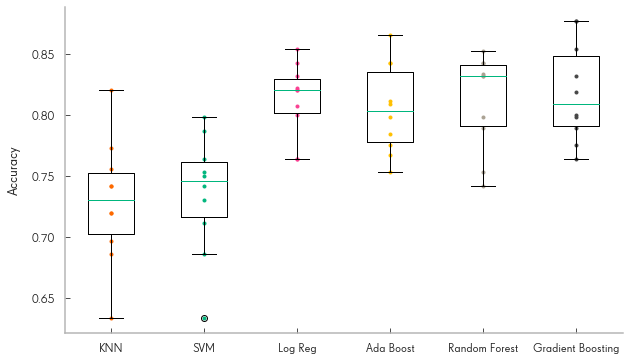

In [433]:
plt.figure(figsize=(10, 6))

# create scatter points 
for i, score in enumerate( scores, start=1): 
    plt.plot([i]*10, score, ".")

plt.boxplot(scores, labels=labels)
plt.ylabel("Accuracy", fontsize=14)
#plt.xlim(-.5,5.5)
#plt.ylim(.5,1)
plt.show()

# Tune final model 

In [434]:
param_distribs = {
        'n_estimators': randint(low=1, high=500),
        'max_features': randint(low=1, high=10),
    }

rnd_search = RandomizedSearchCV(xgb_clf , param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a22ac1e10>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a22ac1358>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [435]:
# rename classifier 
xgb_clf = rnd_search.best_estimator_

## inspect hyperparameters

In [436]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print('score: \t {}  \t \t {}'.format(round(np.sqrt(-mean_score),4 ) , params))


score: 	 0.4048  	 	 {'max_features': 7, 'n_estimators': 436}
score: 	 0.4224  	 	 {'max_features': 8, 'n_estimators': 189}
score: 	 0.4157  	 	 {'max_features': 5, 'n_estimators': 103}
score: 	 0.4211  	 	 {'max_features': 3, 'n_estimators': 215}
score: 	 0.4117  	 	 {'max_features': 8, 'n_estimators': 373}
score: 	 0.4171  	 	 {'max_features': 4, 'n_estimators': 360}
score: 	 0.4329  	 	 {'max_features': 8, 'n_estimators': 131}
score: 	 0.4048  	 	 {'max_features': 6, 'n_estimators': 309}
score: 	 0.4251  	 	 {'max_features': 2, 'n_estimators': 344}
score: 	 0.3964  	 	 {'max_features': 6, 'n_estimators': 386}


In [437]:
# retrieve categorical attribute names 
cat_attribs_encoded= list(full_pipeline.transformers_[1][1].named_steps["cat_encoder"].get_feature_names())
cat_attribs_encoded

['x0_1',
 'x0_2',
 'x0_3',
 'x1_C',
 'x1_Q',
 'x1_S',
 'x2_0.0',
 'x2_1.0',
 'x2_2.0',
 'x2_3.0',
 'x2_4.0',
 'x2_5.0',
 'x3_0',
 'x3_1',
 'x3_2',
 'x3_3',
 'x3_4',
 'x3_5',
 'x4_Miss',
 'x4_Mr',
 'x4_Mrs',
 'x4_Prestige',
 'x5_female',
 'x5_male',
 'x6_0',
 'x6_1']

In [438]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([0.05406721, 0.09975698, 0.08903779, 0.08154099, 0.02904004,
       0.01202898, 0.06795955, 0.00880562, 0.00721714, 0.011022  ,
       0.00339613, 0.00466664, 0.01251558, 0.00481002, 0.00527324,
       0.00439624, 0.00634524, 0.00831559, 0.00491907, 0.00781362,
       0.0074592 , 0.02137301, 0.03278702, 0.15385659, 0.02316205,
       0.01509588, 0.08281799, 0.12840696, 0.00448201, 0.00763163])

In [439]:
trained_columns = num_attribs + cat_attribs_encoded
sorted(zip(feature_importances,trained_columns), reverse=True)

[(0.1538565945347923, 'x4_Mr'),
 (0.12840696375051827, 'x5_male'),
 (0.09975697612594397, 'Fare'),
 (0.08903778813161405, 'Age'),
 (0.08281799427948067, 'x5_female'),
 (0.08154098886094235, 'Name_length'),
 (0.06795954672101269, 'x0_3'),
 (0.05406721473177103, 'RelativesOnboard'),
 (0.032787024188053696, 'x4_Miss'),
 (0.02904003545479657, 'x0_1'),
 (0.023162053920711516, 'x4_Mrs'),
 (0.02137300780511833, 'x3_5'),
 (0.01509587732858813, 'x4_Prestige'),
 (0.012515576325946501, 'x2_2.0'),
 (0.012028982556726268, 'x0_2'),
 (0.011022001029384061, 'x1_S'),
 (0.008805616962294866, 'x1_C'),
 (0.008315589302245479, 'x3_1'),
 (0.007813616671227791, 'x3_3'),
 (0.007631634560004946, 'x6_1'),
 (0.007459200926928632, 'x3_4'),
 (0.007217138895341849, 'x1_Q'),
 (0.006345239968413957, 'x3_0'),
 (0.005273238663013469, 'x2_4.0'),
 (0.004919065398996504, 'x3_2'),
 (0.004810020365574726, 'x2_3.0'),
 (0.004666636406180535, 'x2_1.0'),
 (0.004482006549721196, 'x6_0'),
 (0.004396238382467477, 'x2_5.0'),
 (0.00

In [440]:
xgb_clf.score(X_train, y_train)

0.9461279461279462

## Model metrics

### ROC curve 

In [441]:
y_probas=xgb_clf.predict_proba(X_train)
y_scores = y_probas[:, 1] # score = proba of positive class

In [442]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

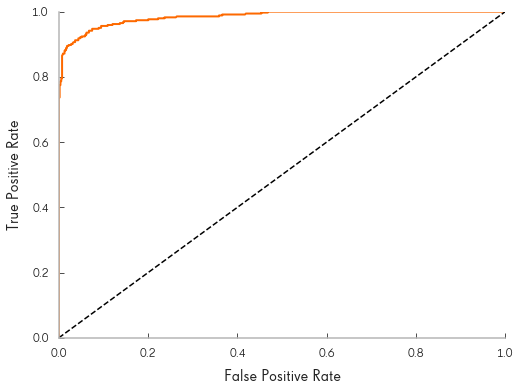

In [443]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()



In [444]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_scores)

0.9843255680184066

In [359]:
y_train_pred = xgb_clf.predict(X_train)
precision_score(y_train, y_train_pred)

0.9619047619047619

In [360]:
recall_score(y_train, y_train_pred)

0.8859649122807017

In [361]:
# f1 score 
f1_score(y_train, y_train_pred)

0.9223744292237442

### Precision recall curve

In [362]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

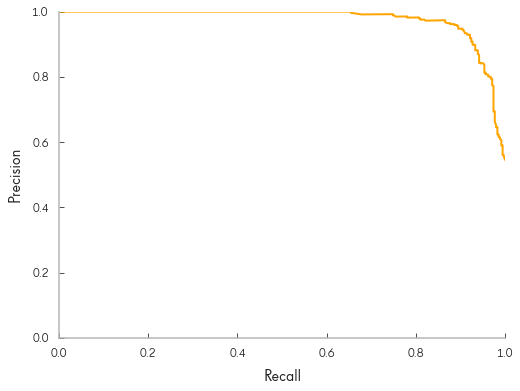

In [363]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "orange", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

# Create prediction file 

In [224]:
X_train.shape

(891, 24)

In [225]:
test_data = load_data("test.csv")

In [226]:
len(test_data)

418

In [227]:
# load test data 
from sklearn.externals import joblib
X_test = joblib.load( 'data/processed/X_test.pkl')

In [ ]:
test_data['Survived'] = xgb_clf.predict(X_test)

In [ ]:
submission = test_data[['PassengerId', 'Survived']]
submission.head()

In [ ]:
# save
submission.to_csv(path_or_buf = 'data/processed/submissions.csv', index=False)

# Ensemble stacking 

In [364]:
from sklearn.ensemble import VotingClassifier
vote_clf=VotingClassifier(estimators=[ ('rf', forest_clf), ('log', log_clf), ('xgb', xgb_clf), ('ada', ada_clf)], voting='soft')
vote_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_we...m='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [365]:
vote_clf.score(X_train, y_train)

0.9382716049382716

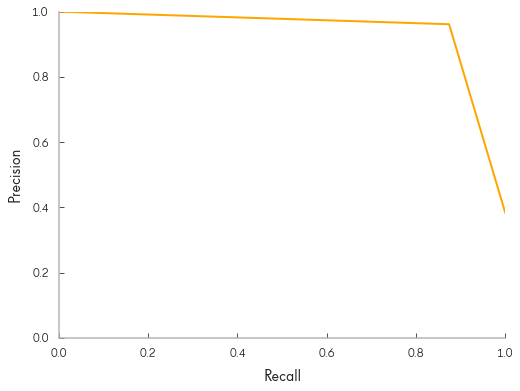

In [366]:
y_scores=vote_clf.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

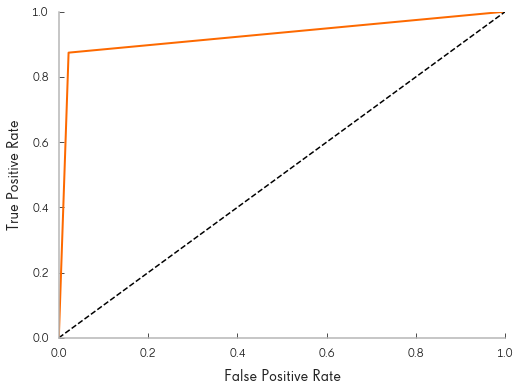

In [367]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [368]:
roc_auc_score(y_train, y_scores)

0.9262055411753427

In [233]:
test_data['Survived'] = vote_clf.predict(X_test)

submission = test_data[['PassengerId', 'Survived']]
submission.head()

# save
submission.to_csv(path_or_buf = 'data/processed/submissions.csv', index=False)

ValueError: Number of features of the model must match the input. Model n_features is 24 and input n_features is 18 

In [ ]:
# Stack with GMM, use this a new feature generator 

In [ ]:
pd.qcut(train_data['Age'], 4, labels=False)

In [ ]:
pd.qcut(train_data['Fare'], 4, labels=False)

In [ ]:
train_data['Age']

In [20]:
train_data['Fare_Bucket'] = add_bucket(train_data['Fare'])
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,RelativesOnboard,traveling_alone,AgeBucket,Fare_Bucket
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0,15.0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,30.0,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,15.0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,30.0,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1,30.0,1
